<a href="https://colab.research.google.com/github/Srihari293/AI_ML/blob/main/SkimLit_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit Project 
Many to one sequence problem

## 1. Dependencies

In [112]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-52732dc5-3360-5133-06e0-ce92e6d33bd2)


In [114]:
# Libraries
import string
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from spacy.lang.en import English
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.utils import plot_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## 2. Downloading dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.


In [ ]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

In [115]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [116]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip']

## 3. Preprocessing data

### 3.1 Data extraction

In [117]:
# Helper function

# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [118]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

FileNotFoundError: ignored

In [119]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  # get all lines from filename
  input_lines = get_lines(filename) 
  # create an empty abstract
  abstract_lines = ""
  # create an empty list of abstracts
  abstract_samples = [] 
  
  # Loop through each line in target file
  for line in input_lines:
    # check to see if line is an ID line
    if line.startswith("###"):
      abstract_id = line
      # reset abstract string
      abstract_lines = "" 
    
    # check to see if line is a new line
    elif line.isspace():  
      # split abstract into separate lines
      abstract_line_split = abstract_lines.splitlines() 

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}                                   # create empty dict to store data from line
        target_text_split = abstract_line.split("\t")    # split target label from text
        line_data["target"] = target_text_split[0]       # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number  # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [120]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

FileNotFoundError: ignored

In [121]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [122]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(11)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [123]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

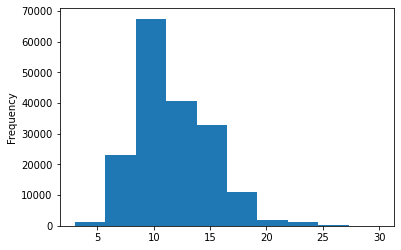

In [124]:
train_df.total_lines.plot.hist();

In [125]:
### Get list of sentences
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [126]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### 3.2 Numerical labelling

In [127]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [128]:
# Label encoding the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [129]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## 4. Modelling experiments

### 4.1 Model 0 - Baseline

In [130]:
# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [131]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [132]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [133]:
# Download helper functions script
!wget https://raw.githubusercontent.com/Srihari293/AI_ML/main/Courses/NLP/helper_functions.py

--2023-02-06 12:22:36--  https://raw.githubusercontent.com/Srihari293/AI_ML/main/Courses/NLP/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10115 (9.9K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-02-06 12:22:36 (104 MB/s) - ‘helper_functions.py.1’ saved [10115/10115]



In [134]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [135]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### 4.2 Preparing text for our deep sequence models

#### 4.2.0 Understanding the data

In [136]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

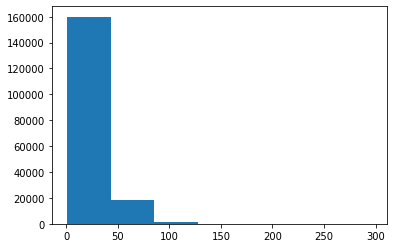

In [137]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [138]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [139]:
# Maximum sentence length in the training set
max(sent_lens)

296

#### 4.2.1 Creating a text vectorizer

In [140]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [141]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [142]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [143]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
we did a phase @/@ study of alectinib to establish the recommended phase @ dose of the drug and examine its activity in patients resistant or intolerant to crizotinib .

Length of text: 30

Vectorized text:
[[   43   112     8   209    17     4 14261     6  1788     2   730   209
    131     4     2   300     3   534   308   190     5    12  2857    16
  10716     6 11674     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [144]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [145]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

#### 4.2.2 Create custom text embedding

In [146]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
we did a phase @/@ study of alectinib to establish the recommended phase @ dose of the drug and examine its activity in patients resistant or intolerant to crizotinib .

Sentence after vectorization (before embedding):
[[   43   112     8   209    17     4 14261     6  1788     2   730   209
    131     4     2   300     3   534   308   190     5    12  2857    16
  10716     6 11674     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.00232147 -0.02417656 -0.04059745 ... -0.01363914 -0.0281348
   -0.00563035]
  [-0.01924269  0.02515921 -0.04962213 ... -0.00706093 -0.03711791
   -0.00310966]
  [ 0.0049219   0.03756447 -0.00301907 ... -0.00551393  0.02098447
    0.02651146]
  ...
  [-0.02432959 -0.02304125  0.01329024 ... -0.02424021 -0.02584848
    0.03604234]
  [-0.02432959 -0.02304125  0.01329024 ... -

#### 4.2.3 Create datasets in TF

In [147]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [148]:
# Loading the TensorSliceDataset's after prefetching them as batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset 

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### 4.3 Model 1: CNN with token embeddings (Conv1d)
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [149]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)       # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)       # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [150]:
# Get summary of Conv1D model
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 5)                 325 

In [151]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9207 - accuracy: 0.6350 - val_loss: 0.6907 - val_accuracy: 0.7397
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6579 - accuracy: 0.7563 - val_loss: 0.6301 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6168 - accuracy: 0.7725 - val_loss: 0.5964 - val_accuracy: 0.7882


In [152]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5988 - accuracy: 0.7865


[0.5988348722457886, 0.786541759967804]

In [153]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.5170650e-01, 1.3840804e-01, 7.8436300e-02, 3.0313936e-01,
        2.8309762e-02],
       [4.7924289e-01, 2.4264508e-01, 1.6815318e-02, 2.5255615e-01,
        8.7404083e-03],
       [1.3662009e-01, 6.8306262e-03, 2.0133378e-03, 8.5449141e-01,
        4.4554974e-05],
       ...,
       [3.2097810e-06, 5.9003389e-04, 5.8215379e-04, 3.2909918e-06,
        9.9882132e-01],
       [6.2143050e-02, 4.6440399e-01, 1.1335438e-01, 7.9314984e-02,
        2.8078356e-01],
       [1.5918320e-01, 7.0949489e-01, 3.6288083e-02, 4.5585010e-02,
        4.9448851e-02]], dtype=float32)

In [154]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [155]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.65417714815305,
 'precision': 0.7837109958052503,
 'recall': 0.7865417714815305,
 'f1': 0.784270507538556}

### 4.4 Model 2: Feature extraction transfer learning model (pre-trained token embeddings):
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

In [156]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, name="universal_sentence_encoder")

In [157]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
however , few placebo-controlled intervention data are available .

Sentence after embedding:
[ 0.04128918 -0.00305117 -0.00745393  0.04825739 -0.04212674 -0.04979823
  0.00891597  0.01142159 -0.00278887  0.00803935  0.05816485  0.04370767
  0.00912943  0.06019857  0.00101787 -0.00746096 -0.04959206 -0.00611257
 -0.03259476 -0.00730088  0.10143685  0.04492236 -0.04732597 -0.05242049
 -0.07270516 -0.01052561  0.0219546  -0.02293471 -0.02203452 -0.0169449 ] (truncated output)...

Length of sentence embedding:
512


In [158]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)          # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
outputs = layers.Dense(5, activation="softmax")(x)             # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [159]:
# Get a summary of the model
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [160]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 15ms/step - loss: 0.9152 - accuracy: 0.6456 - val_loss: 0.7971 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7671 - accuracy: 0.7025 - val_loss: 0.7534 - val_accuracy: 0.7025
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7488 - accuracy: 0.7144 - val_loss: 0.7356 - val_accuracy: 0.7128


In [161]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7378 - accuracy: 0.7156


[0.7377912402153015, 0.7156096696853638]

In [162]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[4.58985150e-01, 3.52327943e-01, 2.96193315e-03, 1.77415207e-01,
        8.30966886e-03],
       [3.34576607e-01, 5.31130433e-01, 3.91238509e-03, 1.27513096e-01,
        2.86741788e-03],
       [2.41740748e-01, 1.19315214e-01, 1.94909237e-02, 5.83891809e-01,
        3.55613008e-02],
       ...,
       [2.15225480e-03, 5.77373384e-03, 4.64866385e-02, 7.99890317e-04,
        9.44787443e-01],
       [3.68974544e-03, 4.53062877e-02, 2.00785816e-01, 1.21279969e-03,
        7.49005318e-01],
       [1.87099248e-01, 2.85827935e-01, 4.56957042e-01, 6.89103687e-03,
        6.32246882e-02]], dtype=float32)

In [163]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [164]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.5609691513306,
 'precision': 0.7158915102288612,
 'recall': 0.715609691513306,
 'f1': 0.7127564056404048}

### 4.5 Model 3:  CNN with character embeddings (Conv1d)
Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.

In [165]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'h o w e v e r   ,   f e w   p l a c e b o - c o n t r o l l e d   i n t e r v e n t i o n   d a t a   a r e   a v a i l a b l e   .'

In [166]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [167]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

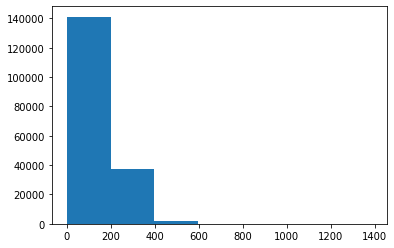

In [168]:
# Check the distribution of our sequences at character-level
plt.hist(char_lens, bins=7);

In [169]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [170]:
# Get all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [171]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [172]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [173]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e s e   f i n d i n g s   s u p p o r t   i n t e r v e n t i o n   f e a s i b i l i t y   ,   a c c e p t a b i l i t y   ,   a n d   p r e l i m i n a r y   e f f i c a c y   .

Length of chars: 81

Vectorized chars:
[[ 3 13  2  9  2 17  4  6 10  4  6 18  9  9 16 14 14  7  8  3  4  6  3  2
   8 21  2  6  3  4  7  6 17  2  5  9  4 22  4 12  4  3 19  5 11 11  2 14
   3  5 22  4 12  4  3 19  5  6 10 14  8  2 12  4 15  4  6  5  8 19  2 17
  17  4 11  5 11 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 

In [174]:
# Character level embedding
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25,             # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False,           # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e s e   f i n d i n g s   s u p p o r t   i n t e r v e n t i o n   f e a s i b i l i t y   ,   a c c e p t a b i l i t y   ,   a n d   p r e l i m i n a r y   e f f i c a c y   .

Embedded chars (after vectorization and embedding):
[[[-0.03371102 -0.02140052 -0.01146943 ... -0.01759604  0.00920017
   -0.03242129]
  [-0.01881181 -0.02805231 -0.0487448  ...  0.03637189 -0.00706861
   -0.04123354]
  [-0.01499099  0.03971045  0.03791125 ... -0.01778495  0.02406498
    0.01658631]
  ...
  [-0.01329926 -0.0416228  -0.02067452 ...  0.04232203 -0.04581741
    0.04721605]
  [-0.01329926 -0.0416228  -0.02067452 ...  0.04232203 -0.04581741
    0.04721605]
  [-0.01329926 -0.0416228  -0.02067452 ...  0.04232203 -0.04581741
    0.04721605]]]

Character embedding shape: (1, 290, 25)


In [175]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [176]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 5

In [177]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [178]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 [==============================] - 4s 6ms/step - loss: 1.2650 - accuracy: 0.4870 - val_loss: 1.0427 - val_accuracy: 0.5775
Epoch 2/10
562/562 [==============================] - 4s 6ms/step - loss: 1.0095 - accuracy: 0.5939 - val_loss: 0.9492 - val_accuracy: 0.6207
Epoch 3/10
562/562 [==============================] - 4s 6ms/step - loss: 0.9344 - accuracy: 0.6315 - val_loss: 0.8762 - val_accuracy: 0.6553
Epoch 4/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8810 - accuracy: 0.6581 - val_loss: 0.8438 - val_accuracy: 0.6666
Epoch 5/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8632 - accuracy: 0.6628 - val_loss: 0.8216 - val_accuracy: 0.6785
Epoch 6/10
562/562 [==============================] - 4s 7ms/step - loss: 0.8403 - accuracy: 0.6748 - val_loss: 0.8013 - val_accuracy: 0.6855
Epoch 7/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8275 - accuracy: 0.6769 - val_loss: 0.7864 - val_accuracy: 0.6888
Epoch 

In [179]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7690 - accuracy: 0.7031


[0.769029974937439, 0.7030649781227112]

In [180]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.42467833, 0.23105443, 0.06461909, 0.22576492, 0.05388326],
       [0.17532848, 0.61286694, 0.00849038, 0.16934058, 0.03397362],
       [0.17620727, 0.2204142 , 0.02701677, 0.56008095, 0.01628091],
       ...,
       [0.01264793, 0.01783531, 0.13738309, 0.02108396, 0.81104976],
       [0.05070361, 0.27814022, 0.34245875, 0.10317268, 0.22552477],
       [0.27283922, 0.5996261 , 0.09830811, 0.02447406, 0.00475257]],
      dtype=float32)

In [181]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 1])>

In [182]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 70.30650072818747,
 'precision': 0.6980601635053585,
 'recall': 0.7030650072818747,
 'f1': 0.6992288603082952}

### 4.6 Model 4: Multi-modal model (Hybrid pre-trained token embeddings and character embeddings)

In [183]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [184]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

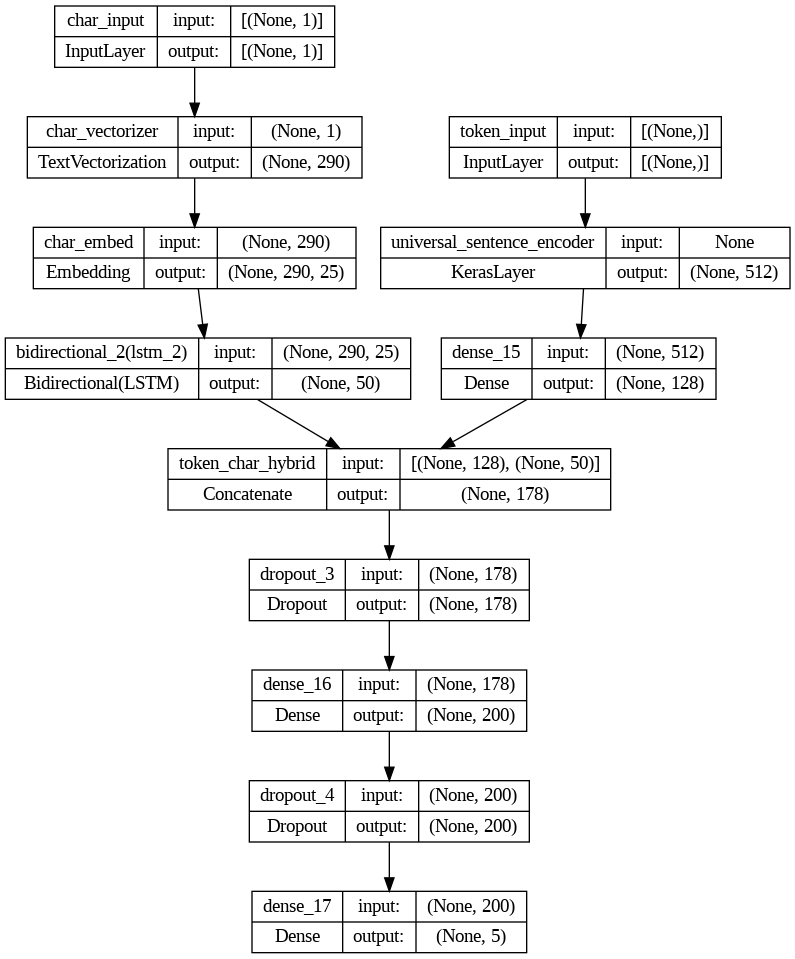

In [185]:
# Plot hybrid token and character model
plot_model(model_4, show_shapes = True)

In [186]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [187]:
# Combining the token and character into the dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [188]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [189]:
# Fitting the model
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 33ms/step - loss: 0.9684 - accuracy: 0.6155 - val_loss: 0.7649 - val_accuracy: 0.7051
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7902 - accuracy: 0.6965 - val_loss: 0.7043 - val_accuracy: 0.7380
Epoch 3/3
562/562 [==============================] - 18s 31ms/step - loss: 0.7598 - accuracy: 0.7087 - val_loss: 0.6764 - val_accuracy: 0.7477


In [190]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6835 - accuracy: 0.7387


[0.6834984421730042, 0.7387130856513977]

In [191]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 17s 17ms/step


array([[3.9812517e-01, 3.4456423e-01, 2.7271549e-03, 2.4486957e-01,
        9.7139087e-03],
       [3.5383624e-01, 4.0822375e-01, 3.4966792e-03, 2.3323411e-01,
        1.2091706e-03],
       [3.4649175e-01, 7.1628347e-02, 2.5096664e-02, 5.4183757e-01,
        1.4945672e-02],
       ...,
       [6.0308864e-04, 7.0713656e-03, 5.3880088e-02, 2.2949350e-04,
        9.3821597e-01],
       [8.3780540e-03, 5.9642166e-02, 2.1555910e-01, 3.2281587e-03,
        7.1319252e-01],
       [2.4563684e-01, 4.2557693e-01, 2.5007808e-01, 2.7353864e-02,
        5.1354267e-02]], dtype=float32)

In [192]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [193]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.87130941347809,
 'precision': 0.7379294847693605,
 'recall': 0.7387130941347809,
 'f1': 0.7364392565287927}

### 4.7 Model 5 - Feature extraction transfer learning model (pre-trained token , character and positional embeddings):

In [194]:
# Trying to feature enginner the order into likehood of a particular class.
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


#### 4.7.1 Create positinoal embeddings

In [195]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

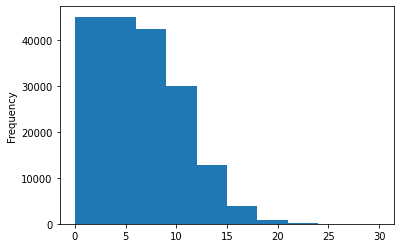

In [196]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [197]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [198]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [199]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

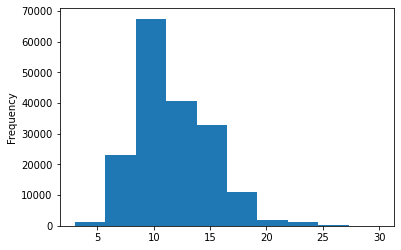

In [200]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [201]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [202]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#### 4.7.2 Creating a hybrid embedding model

In [203]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [204]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

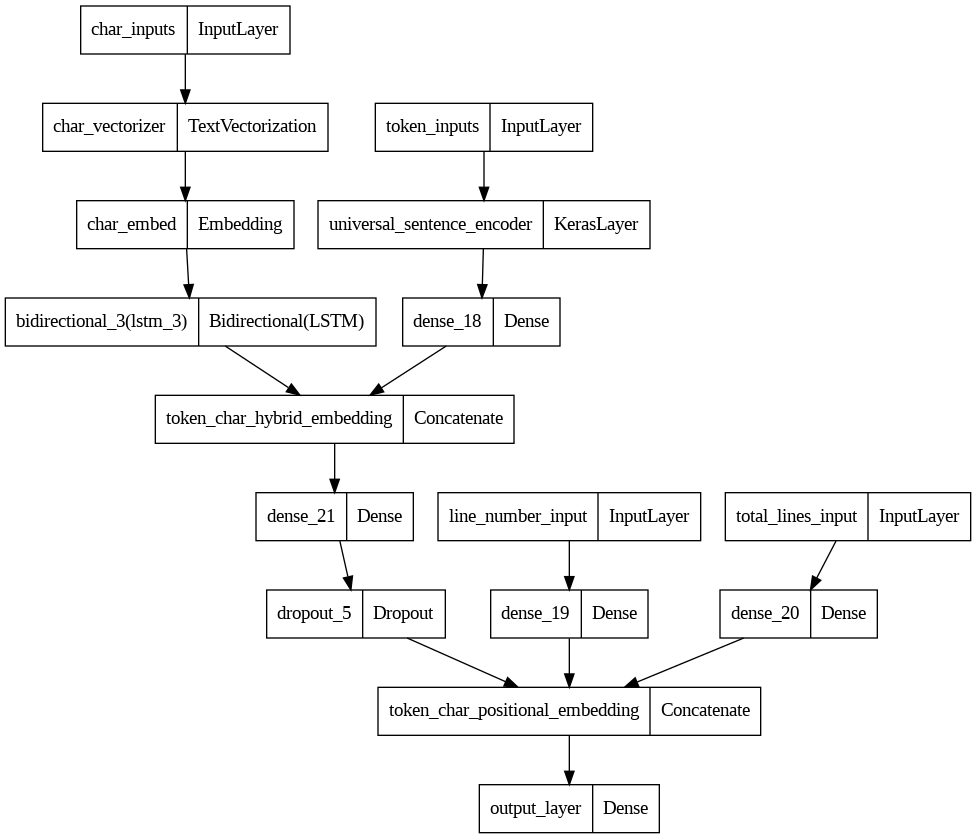

In [205]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [206]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f14206ae790> True
<keras.engine.input_layer.InputLayer object at 0x7f142573a4f0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f13940f23d0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f14208c71f0> False
<keras.layers.core.embedding.Embedding object at 0x7f1361308c10> True
<keras.layers.core.dense.Dense object at 0x7f14206aeaf0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f141f487e20> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f141f4a7df0> True
<keras.engine.input_layer.InputLayer object at 0x7f1394146280> True
<keras.engine.input_layer.InputLayer object at 0x7f1443a7abb0> True
<keras.layers.core.dense.Dense object at 0x7f1394145fa0> True
<keras.layers.core.dense.Dense object at 0x7f1443c4de50> True
<keras.layers.core.dense.Dense object at 0x7f142066fa60> True
<keras.layers.regularization.dropout.Dropout object at 0x7f1394151eb0> True
<keras.layers

In [207]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [208]:
# Creating the callbacks 
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath , 
                                                               save_weights_only = True , 
                                                               save_best_only = True  , 
                                                               save_freq = 'epoch' , 
                                                               monitor = 'val_loss')

early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, 
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [209]:
# Fit the token, char and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) ,
                    optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['accuracy'])

history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data = val_pos_char_token_dataset, 
                              callbacks = [early_stopping , model_checkpoint_callback , reduce_lr])

Epoch 1/5
562/562 [==============================] - 41s 65ms/step - loss: 1.0988 - accuracy: 0.7242 - val_loss: 0.9865 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 2/5
562/562 [==============================] - 35s 63ms/step - loss: 0.9641 - accuracy: 0.8183 - val_loss: 0.9464 - val_accuracy: 0.8249 - lr: 0.0010
Epoch 3/5
562/562 [==============================] - 35s 63ms/step - loss: 0.9482 - accuracy: 0.8260 - val_loss: 0.9351 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 4/5
562/562 [==============================] - 36s 63ms/step - loss: 0.9384 - accuracy: 0.8355 - val_loss: 0.9262 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 4: early stopping


In [210]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[0.6696106 , 0.08986536, 0.01514501, 0.20804246, 0.01733661],
       [0.70780396, 0.07736482, 0.05399376, 0.15213181, 0.00870569],
       [0.4439118 , 0.09470848, 0.11233951, 0.2999562 , 0.049084  ],
       ...,
       [0.02609802, 0.08980288, 0.03637142, 0.02632923, 0.82139844],
       [0.02941698, 0.27472618, 0.07985819, 0.02836361, 0.58763504],
       [0.09558322, 0.7438796 , 0.08465194, 0.02263763, 0.05324754]],
      dtype=float32)

In [211]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [212]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.60916192241493,
 'precision': 0.8426601305820987,
 'recall': 0.8360916192241493,
 'f1': 0.8312188672942019}

## 5. Comparing models

In [213]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.654177,0.783711,0.786542,0.784271
pretrained_token_embed,71.560969,0.715892,0.715610,0.712756
custom_char_embed_conv1d,70.306501,0.698060,0.703065,0.699229
hybrid_char_token_embed,73.871309,0.737929,0.738713,0.736439
tribrid_pos_char_token_embed,83.609162,0.842660,0.836092,0.831219


In [214]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

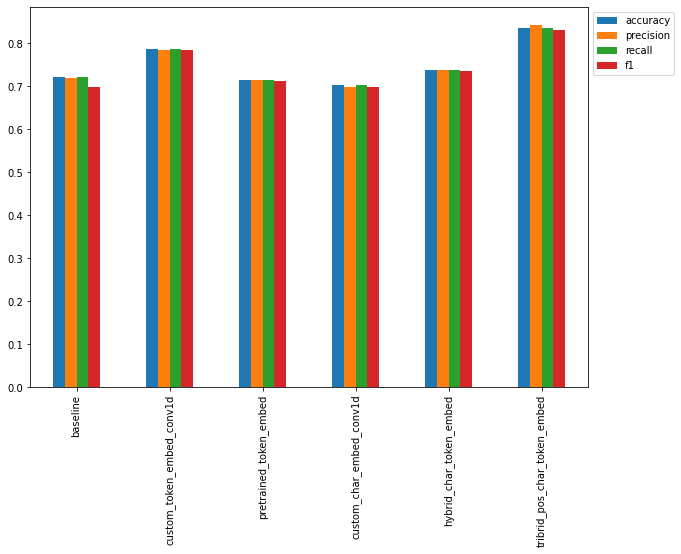

In [215]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

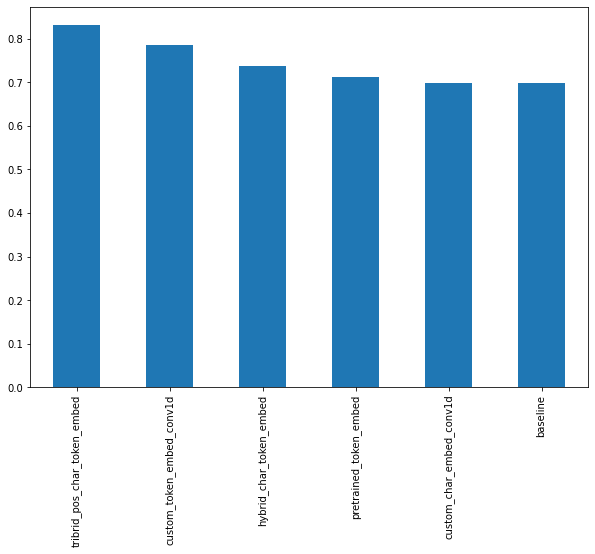

In [216]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## 6. Make predictions

In [217]:
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-02-06 12:29:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-02-06 12:29:44 (89.2 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [218]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [219]:
# How does our abstracts look in a DataFrame? 
pd.DataFrame(example_abstracts)

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [220]:
def visualize_pred_sequence_labels(abstract_dict , model , label_encoder):

  '''
  
    Takes in a list of dictionaries of abstracts, 

    [{'abstract': 'This RCT examined .......' , 
      'details': 'RCT of a manuali......',
      'source': 'https://pubmed.ncbi.nlm........./'},..........] 

    Arguments: 
    ----------
      - abstract_dict : Abstract dictionary of the above format 
      - model : the trained model on the same data format (line_numbers,  total_lines , sentences , characters)
      - label_encoder : the label encoder used to encode the classes 

    Returns:
    --------
      Prints out the predicted label and the corresponding sequence/ text 
  '''

  # Setup english sentence parser 
  nlp = English()

  # Create sentence splitting pipeline object 
  # sentencizer = nlp.create_pipe('sentencizer')
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract_dict[0]['abstract'])

  # Return detected sentences from doc in string typpe 
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines 
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features 
  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i 
    sample_dict['total_lines'] = total_lines_in_sample - 1 
    sample_lines.append(sample_dict)

  
  # Get all line number and total lines numbers then one hot encode them 
  abstract_line_numbers = [line['line_number'] for line in sample_lines]
  abstract_total_lines = [line['total_lines'] for line in sample_lines]

  abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # Split the lines into characters 
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (abstract_line_numbers_one_hot, 
                                           abstract_total_lines_one_hot , 
                                           tf.constant(abstract_lines) , 
                                           tf.constant(abstract_chars)))
  
  # Turn prediction probs to pred class 
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)
  
  # Prediction class integers into string class name 
  abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels 
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')

In [221]:
visualize_pred_sequence_labels(example_abstracts , model_5 , label_encoder)

1/1 [==============================] - 1s 978ms/step
OBJECTIVE:  This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS:  Participants were randomly assigned to treatment or wait-list conditions.

METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

RESULTS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

METHODS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

RESULTS:  Standardized effect size estimates were primarily in the medium and large ran